In [1]:
from model import *

/home/lambda/miniconda3/envs/deep_310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = WhisperEncoderWithHead()
model.load_state_dict(torch.load('model_clean.pt'))

#set model to eval
model.eval()

WhisperEncoderWithHead(
  (encoder): WhisperEncoder(
    (conv1): Conv1d(80, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(1024, 1024, kernel_size=(3,), stride=(2,), padding=(1,))
    (embed_positions): Embedding(1500, 1024)
    (layers): ModuleList(
      (0-23): 24 x WhisperEncoderLayer(
        (self_attn): WhisperAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): GELUActivation()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, eleme

In [3]:
import torchaudio
import IPython.display as ipd

#load clip
clip, sr = torchaudio.load("father.wav", normalize=True)

#load wandb whisper preprocessor
processor = WhisperProcessor.from_pretrained('openai/whisper-large-v2')

#preprocess the clip
clip = clip.mean(0, keepdim=True)

#downsample to 16khz
clip = torchaudio.transforms.Resample(sr, 16000)(clip)
sr = 16000

# #cut the clip to 30s
clip = clip[0, 18*16000:(18+30)*16000]


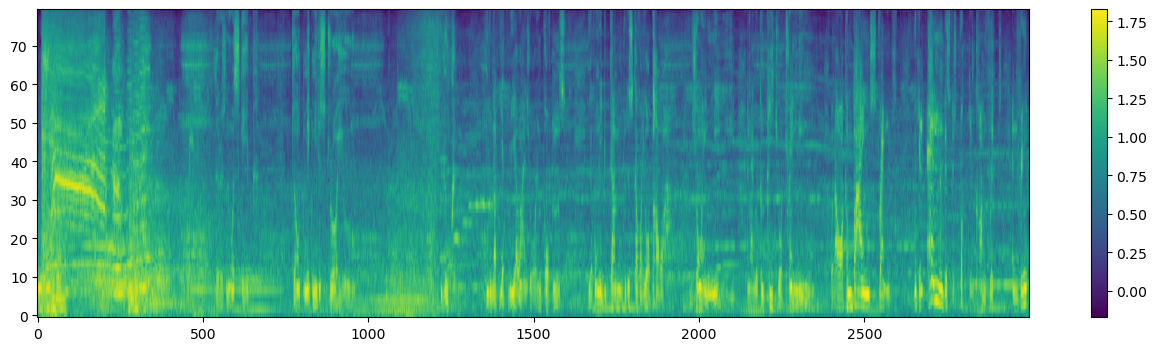

In [4]:
import matplotlib.pyplot as plt
features = processor(clip, sampling_rate=sr, return_tensors="pt", do_normalize=True).input_features

#plot the features as spectrogram
plt.figure(figsize=(16, 4))
plt.imshow(features[0].cpu().numpy(), aspect="auto", origin="lower")
plt.colorbar()
plt.show()


In [5]:
labels = model.forward(features)

#try logit adjustment or comment it out
# labels = labels - torch.log(model.logit_scaling**1 + 1e-12)


In [6]:
#play the clip in the notebook
ipd.Audio(clip, rate=sr)

In [7]:
import numpy as np
indices = np.asarray(['happiness', 'sadness', 'disgust', 'fear', 'surprise', 'anger', 'other', 'neutral'])

#create pooled_labels by averaging every 50 frames
pooled_labels = F.avg_pool1d(labels[0].transpose(0, 1).unsqueeze(0), kernel_size=50).squeeze(0).transpose(0, 1)


print(pooled_labels.shape)

#argmax to get the most likely token and print sequence of emotions for every second of the clip
print(indices[torch.argmax(pooled_labels, dim=-1)[:].cpu().numpy()])

#print the probabilities of each token
print(pooled_labels[:].float().detach().cpu().numpy())


#fear -> sad -> neutral -> anger

torch.Size([30, 8])
['fear' 'fear' 'other' 'neutral' 'neutral' 'sadness' 'sadness' 'sadness'
 'sadness' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral' 'neutral'
 'neutral' 'anger' 'neutral' 'anger' 'anger' 'anger' 'anger' 'neutral']
[[-1.243858   -1.0467963  -1.0185776   1.196219   -1.2320408  -1.3664391
  -1.0471618   0.34088743]
 [-1.5853202  -0.6965575  -1.234658    2.009556   -1.4682454  -1.1124431
  -1.1924472  -0.00746967]
 [-1.8429314  -0.43862632 -1.0360852  -0.05556916 -1.5369248  -1.4154139
   0.66396433  0.1848234 ]
 [-1.6573368  -0.1898694  -0.67565656 -0.970289   -1.6761206  -1.7284201
   0.6194074   0.7330518 ]
 [-1.8136797   0.18038157 -0.31848022 -1.3030198  -1.3509642  -1.778646
   0.04470692  0.81896174]
 [-1.676043    0.64313924 -0.08784994 -1.5493786  -1.5278107  -0.97414863
  -0.73426527  0.42058402]
 [-1.4337567   1.0191758  -0.23866422 -1.2447487  -1.4426377  -1.2986238
  -1.5472937   0.660